# **Modelo 01**
---

En este segundo cuaderno, cargaremos el dataset limpio y empezaremos con un primer analisis en modelos de ML.

### **1: Carga de Datos y Definición de Variables**

El primer paso en este nuevo notebook es cargar el dataset que acabamos de crear. Luego, separaremos claramente nuestras variables en tres grupos:

1.  **Variable Objetivo (y):** Lo que queremos predecir. En nuestro caso, es la columna `Casos`.
2.  **Características Predictoras (X):** Todas las columnas que usaremos para hacer la predicción. Esto incluye las variables climáticas originales, nuestras nuevas características de *lag* departamental y las características autorregresivas.
3.  **Metadatos:** Columnas que no usaremos para entrenar el modelo (como `Departamento`, `Provincia`, `Distrito`), pero que son útiles para identificar y analizar las predicciones más tarde.

---

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 1. Carga del Dataset Procesado
# Cargamos el archivo CSV que generamos en el notebook anterior.
file_path = 'Dengue_procesado_para_modelo_lags_depto.csv'

try:
    df_model = pd.read_csv(file_path, index_col='Fecha', parse_dates=True)
    print("Archivo procesado cargado exitosamente.")
    print(f"El dataset para el modelo tiene {df_model.shape[0]} filas y {df_model.shape[1]} columnas.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{file_path}'")
    print("Por favor, asegúrate de haber ejecutado el notebook 01_Exploracion_y_Limpieza.ipynb primero.")

# 2. Definición de la Variable Objetivo y las Características Predictoras
# Variable que queremos predecir
target = 'Casos'

# Columnas que son identificadores o metadatos, no características de entrenamiento
metadata_cols = ['Departamento', 'Provincia', 'Distrito', 'UBIGEO', 'Ano', 'Semana']

# Todas las demás columnas son nuestras características predictoras (features)
# Nos aseguramos de excluir la variable objetivo y los metadatos
features = [col for col in df_model.columns if col != target and col not in metadata_cols]

# Separamos el DataFrame en X (características) e y (objetivo)
X = df_model[features]
y = df_model[target]

print("\n--- Definición de Variables ---")
print(f"Variable Objetivo (y): '{target}'")
print(f"Número de Características Predictoras (X): {len(features)}")
print(features)
print("Ejemplos de características:", features[:5])

# Mostramos las dimensiones para verificar
print("\nDimensiones de los dataframes:")
print(f"X (características): {X.shape}")
print(f"y (objetivo): {y.shape}")

Archivo procesado cargado exitosamente.
El dataset para el modelo tiene 817643 filas y 26 columnas.

--- Definición de Variables ---
Variable Objetivo (y): 'Casos'
Número de Características Predictoras (X): 19
['tmean', 'tmax', 'tmin', 'humr', 'ptot', 'tmean_clima', 'tmax_clima', 'tmin_clima', 'humr_clima', 'ptot_clima', 'tmean_lag_depto', 'tmax_lag_depto', 'tmin_lag_depto', 'humr_lag_depto', 'ptot_lag_depto', 'Casos_lag1', 'Casos_lag2', 'Casos_lag3', 'Casos_lag4']
Ejemplos de características: ['tmean', 'tmax', 'tmin', 'humr', 'ptot']

Dimensiones de los dataframes:
X (características): (817643, 19)
y (objetivo): (817643,)


### **2: Análisis de la Distribución Temporal de Datos y División Estratégica**

**Justificación Metodológica:**

Un principio clave en Machine Learning es asegurar que los conjuntos de entrenamiento y prueba sean representativos del problema que queremos resolver.  
El artículo de Sebastianelli et al. lo demuestra al seleccionar un largo período de entrenamiento (2001-2016) que captura múltiples brotes epidémicos, y un período de prueba (2017-2019) que incluye un brote significativo.  
De manera similar, Caro Ferreyra analiza períodos específicos (como el año 2023) precisamente porque fue un año de alta incidencia y, por lo tanto, de gran interés.  

Nuestro objetivo es el mismo:  
- **Analizar la distribución de los datos:** Visualizaremos la suma total de casos de dengue por semana en todo el Perú para entender qué años tienen alta y baja incidencia, e identificar el período anómalo de la pandemia.  
- **División Estratégica inicial:** En lugar de una fecha fija, usaremos `train_test_split` de Scikit-learn respetando el orden cronológico. Por ejemplo, reservaremos el último **20%** del período de tiempo para la prueba, asegurando que probamos con los datos más recientes y con una mezcla de años de alta y baja incidencia.  

---

### **2.1: Consideración Especial — Períodos Anómalos**

No todos los años del dataset reflejan la dinámica real del dengue:  
- **Silencio Epidemiológico (2018-2020):** Durante este período se reportaron “0 casos”, pero no necesariamente por ausencia de dengue, sino por falta de reporte. Esto introduce un sesgo: el modelo podría aprender falsamente que, bajo ciertas condiciones climáticas, no hay transmisión.  
- **Período Pandémico (2020-2022):** La movilidad reducida y la priorización del sistema de salud en COVID-19 alteraron drásticamente la dinámica de transmisión. Los patrones de estos años no son representativos de condiciones normales y podrían generar correlaciones espurias.  

Si se incluyen estos períodos en el entrenamiento, se “envenena” el dataset y el modelo tendería a subestimar los brotes futuros o a aprender relaciones no generalizables.  

Por lo tanto, la estrategia final será:
- **Mantener la división cronológica:** Usaremos datos antiguos para entrenar y los más recientes para probar.  
- **Filtrar el entrenamiento:** Excluiremos de `(X_train, y_train)` los registros que caen en los períodos de silencio epidemiológico y pandemia.  
- **Preservar el conjunto de prueba:** `(X_test, y_test)` se mantendrá intacto. Esto es fundamental para evaluar al modelo en escenarios futuros, incluso si son atípicos.  

**Beneficio esperado:**  
El modelo se entrenará con datos **“limpios y representativos”** (incluyendo brotes clave como el de 2017 y los mega-brotes de 2023-2024). Así, aprenderá las dinámicas fundamentales de transmisión del dengue y luego será evaluado en condiciones reales.  

---


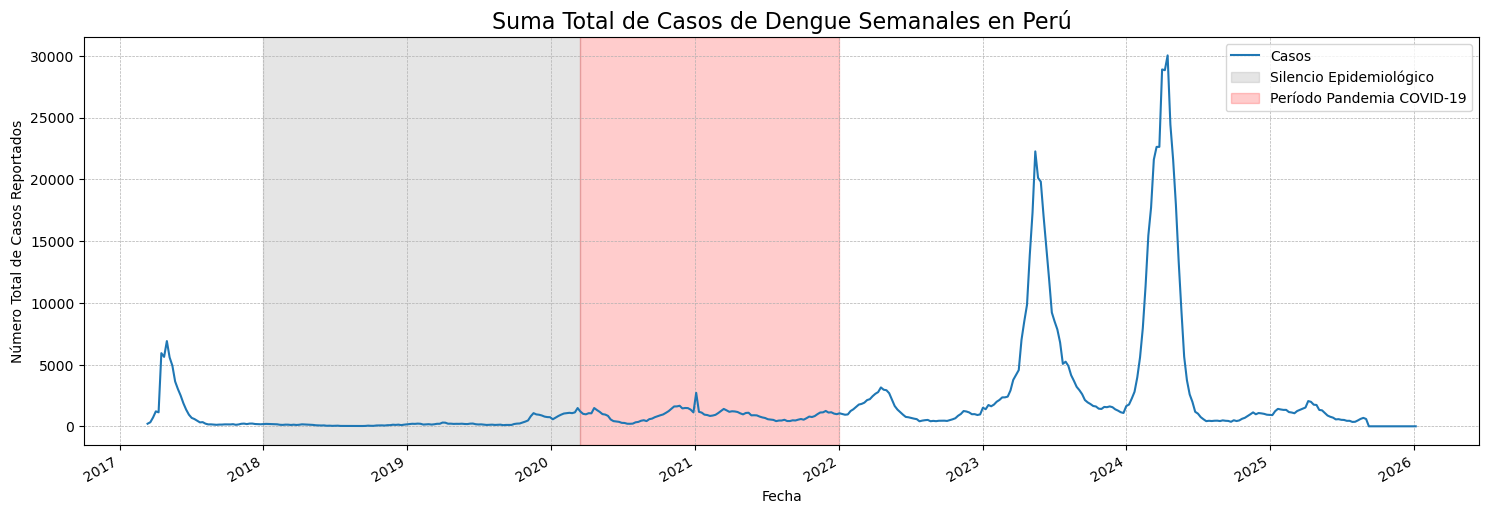

La fecha de corte para la división es: 2024-04-01

--- Tamaño de los Conjuntos de Datos ---
Conjunto de Entrenamiento Original (antes de filtrar): 653479 filas
Conjunto de Entrenamiento Final (excluyendo periodos anómalos): 276443 filas
  Rango de fechas (discontinuo): 2017-03-13 a 2024-04-01

Conjunto de Prueba (Test) - Sin cambios: 164164 filas
  Rango de fechas: 2024-04-08 a 2026-01-05


In [6]:
# Exclusión Estratégica de Períodos Anómalos 

# 1. ANÁLISIS DE LA DISTRIBUCIÓN DE DATOS 
casos_nacionales_semanal = df_model['Casos'].groupby(df_model.index).sum()
plt.figure(figsize=(18, 6))
casos_nacionales_semanal.plot()
plt.title('Suma Total de Casos de Dengue Semanales en Perú', fontsize=16)
plt.ylabel('Número Total de Casos Reportados')
plt.xlabel('Fecha')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Definimos los periodos a visualizar y excluir
periodo_silencio = ('2018-01-01', '2020-03-14')
periodo_pandemia = ('2020-03-15', '2022-01-01')
plt.axvspan(periodo_silencio[0], periodo_silencio[1], color='gray', alpha=0.2, label='Silencio Epidemiológico')
plt.axvspan(periodo_pandemia[0], periodo_pandemia[1], color='red', alpha=0.2, label='Período Pandemia COVID-19')
plt.legend()
plt.show()


# 2. DIVISIÓN CRONOLÓGICA INICIAL
# Primero, hacemos la división cronológica
test_size_percentage = 0.20
unique_dates = sorted(X.index.unique())
split_index = int(len(unique_dates) * (1 - test_size_percentage))
fecha_corte = unique_dates[split_index]

X_train_full = X.loc[X.index <= fecha_corte]
y_train_full = y.loc[y.index <= fecha_corte]
X_test = X.loc[X.index > fecha_corte]
y_test = y.loc[y.index > fecha_corte]


# 3. EXCLUSIÓN ESTRATÉGICA DEL CONJUNTO DE ENTRENAMIENTO
# Ahora, filtramos X_train_full y y_train_full para excluir los periodos anómalos.
# Creamos una máscara booleana que es 'True' para las fechas que queremos conservar.
mask_silencio = (X_train_full.index < periodo_silencio[0]) | (X_train_full.index > periodo_silencio[1])
mask_pandemia = (X_train_full.index < periodo_pandemia[0]) | (X_train_full.index > periodo_pandemia[1])

# El conjunto de entrenamiento final solo contiene las filas que están fuera de AMBOS periodos anómalos.
X_train = X_train_full[mask_silencio & mask_pandemia]
y_train = y_train_full[mask_silencio & mask_pandemia]


print(f"La fecha de corte para la división es: {fecha_corte.date()}")
print("\n--- Tamaño de los Conjuntos de Datos ---")
print(f"Conjunto de Entrenamiento Original (antes de filtrar): {X_train_full.shape[0]} filas")
print(f"Conjunto de Entrenamiento Final (excluyendo periodos anómalos): {X_train.shape[0]} filas")
print(f"  Rango de fechas (discontinuo): {X_train.index.min().date()} a {X_train.index.max().date()}")
print(f"\nConjunto de Prueba (Test) - Sin cambios: {X_test.shape[0]} filas")
print(f"  Rango de fechas: {X_test.index.min().date()} a {X_test.index.max().date()}")

---
### **3: Entrenamiento del Modelo Baseline (XGBoost)**
**Justificación Metodológica:**

Como modelo inicial, necesitamos algo que sea potente, rápido y que nos ofrezca interpretabilidad. Podríamos usar Random Forest, pero XGBoost (Extreme Gradient Boosting) suele ser una opción superior. Es una implementación optimizada del gradient boosting, un enfoque de ensamble muy potente que construye modelos de forma secuencial, donde cada nuevo modelo corrige los errores del anterior.

El paper de Sebastianelli et al. utiliza CatBoost, que es de la misma familia de algoritmos de gradient boosting. Al usar XGBoost, estamos adoptando un enfoque de última generación, similar al de las referencias, que es conocido por su excelente rendimiento en datos tabulares como los nuestros. Además, nos permitirá, al igual que Random Forest, calcular la importancia de las características para entender qué variables son las más predictivas.

In [8]:
#  3. Entrenamiento del Modelo Base (XGBoost) 

print("Iniciando el entrenamiento del modelo XGBoost...")
print(f"Entrenando con {X_train.shape[0]} filas de datos 'limpios'.")

# Inicializamos el modelo XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# Entrenamos el modelo usando nuestros datos de entrenamiento filtrados
xgb_model.fit(X_train, y_train)

print("\n¡Entrenamiento completado!")

# 4. Realizar Predicciones en el Conjunto de Prueba
print("Realizando predicciones en el conjunto de prueba...")
y_pred = xgb_model.predict(X_test)

print("Predicciones completadas.")

# 5. Evaluación Inicial del Modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Resultados de la Evaluación del Modelo ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Interpretación del R²
if r2 > 0.7:
    print("Interpretación: El modelo explica una porción muy buena de la variabilidad de los casos.")
elif r2 > 0.4:
    print("Interpretación: El modelo tiene un poder predictivo moderado pero útil.")
else:
    print("Interpretación: El modelo tiene un bajo poder predictivo. Se necesita más trabajo en las características o el modelo.")

Iniciando el entrenamiento del modelo XGBoost...
Entrenando con 276443 filas de datos 'limpios'.

¡Entrenamiento completado!
Realizando predicciones en el conjunto de prueba...
Predicciones completadas.

--- Resultados de la Evaluación del Modelo ---
Raíz del Error Cuadrático Medio (RMSE): 5.4595
Coeficiente de Determinación (R²): 0.9080
Interpretación: El modelo explica una porción muy buena de la variabilidad de los casos.


---

### **4: Análisis del Modelo - Importancia de las Características**

Por ahora vemos que el entrenamiento nos está dando aparentemente buenos resultados, Un R² de 0.9080 es bastante alto. Significa que el modelo, utilizando las características que diseñamos, es capaz de explicar el 90.8% de la variabilidad en los casos de dengue del conjunto de prueba. El siguiente paso sería dar una interpretabilidad al modelo usado.

**Justificación Metodológica:**

Una de las mayores ventajas de los modelos basados en árboles (como XGBoost y Random Forest, usados en el paper de Sebastianelli et al.) es su capacidad para medir la "importancia" de cada característica. El modelo nos puede decir exactamente qué variables (p. ej., tmean_lag_depto, Casos_lag1, ptot_lag_depto) fueron las más útiles para hacer sus predicciones.

Este análisis no solo valida la feature engineering, sino que también nos da insights epidemiológicos: ¿Es más importante la temperatura pasada, la lluvia reciente o el número de casos de la semana anterior?

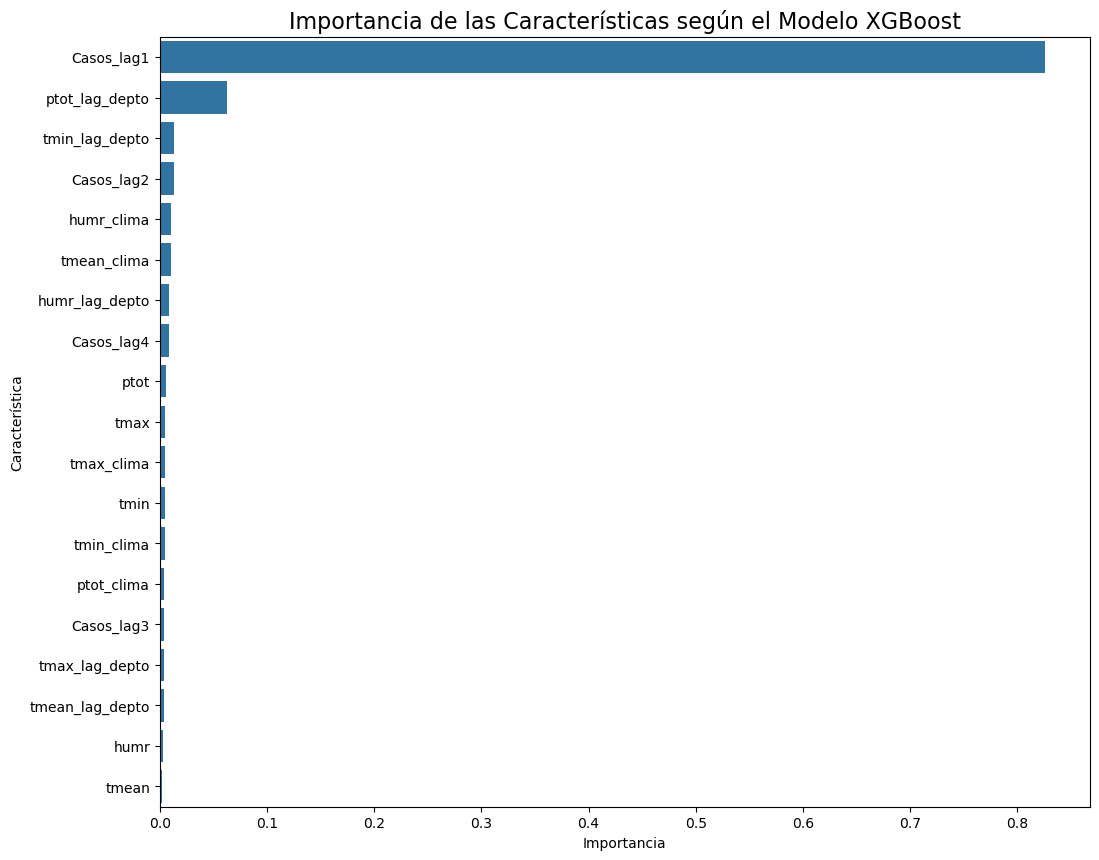

--- Top 5 Características Más Predictivas ---
           feature  importance
15      Casos_lag1    0.826259
14  ptot_lag_depto    0.062523
12  tmin_lag_depto    0.013694
16      Casos_lag2    0.013145
8       humr_clima    0.010104


In [9]:
# 4. Análisis del Modelo: Importancia de las Características

# Extraemos la importancia de las características del modelo ya entrenado
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Creamos un DataFrame para facilitar la visualización
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualización de la Importancia
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importancia de las Características según el Modelo XGBoost', fontsize=16)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

# Imprimimos las 5 características más importantes
print("--- Top 5 Características Más Predictivas ---")
print(feature_importance_df.head(5))

### **5: Análisis del Modelo - Visualización de Predicciones vs. Reales**

**Justificación Metodológica:**
Las métricas como R² nos dan un resumen numérico del rendimiento, pero no nos dicen dónde y cómo falla o acierta el modelo. El paper de Sebastianelli et al. dedica varias figuras a graficar las predicciones del modelo contra los datos observados a lo largo del tiempo. Esto permite una evaluación cualitativa crucial. ¿El modelo captura los picos de los brotes? ¿Predice correctamente la estacionalidad?

Graficaremos la suma total de casos reales del conjunto de prueba (y_test) y la compararemos con la suma total de nuestras predicciones (y_pred) para el mismo período. Esto nos dará una visión macro de qué tan bien se comporta nuestro modelo en el tiempo.

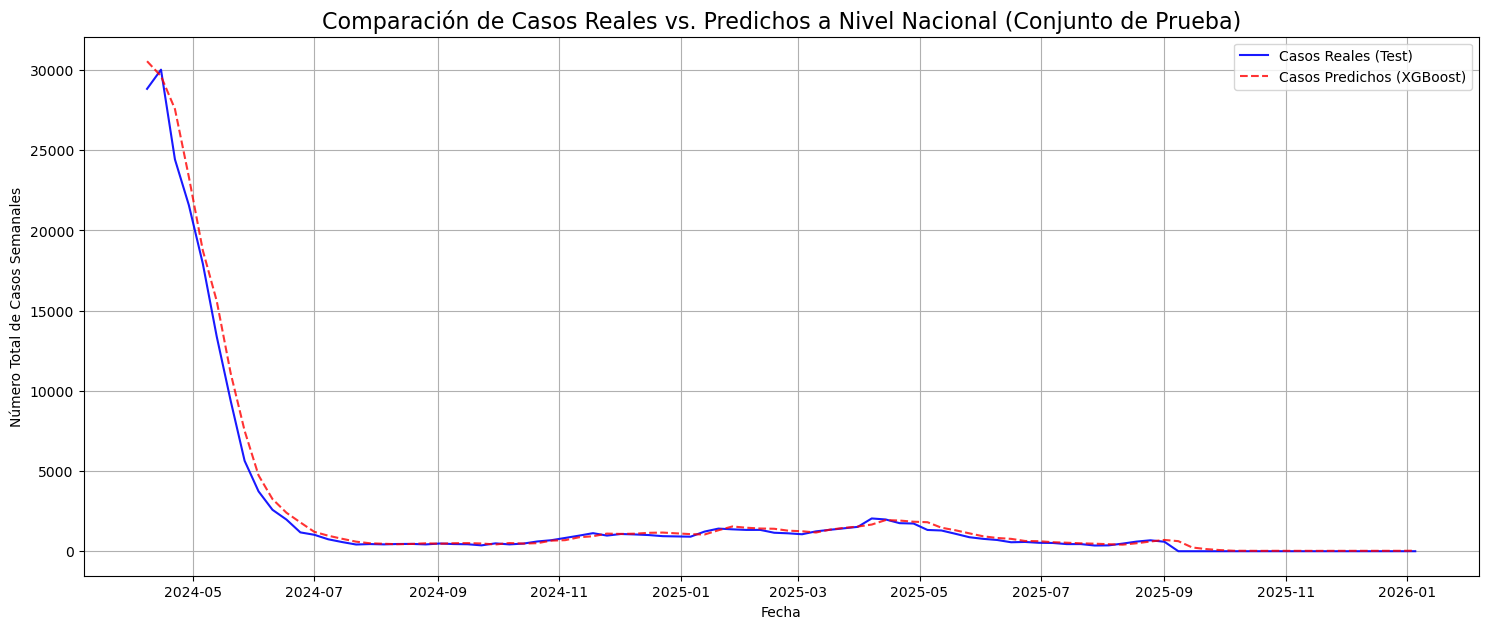

In [10]:
# 5. Análisis del Modelo: Visualización de Predicciones vs. Reales

# Creamos un DataFrame para comparar fácilmente los valores reales y predichos
# Las predicciones deben tener los mismos indices de fecha que los valores reales.
results_df = pd.DataFrame({
    'Casos_Reales': y_test,
    'Casos_Predichos': y_pred
}, index=y_test.index)

# Agrupamos por semana para ver la tendencia nacional
reales_agg = results_df['Casos_Reales'].groupby(results_df.index).sum()
predichos_agg = results_df['Casos_Predichos'].groupby(results_df.index).sum()

# Visualización
plt.figure(figsize=(18, 7))
plt.plot(reales_agg.index, reales_agg, label='Casos Reales (Test)', color='blue', alpha=0.9)
plt.plot(predichos_agg.index, predichos_agg, label='Casos Predichos (XGBoost)', color='red', linestyle='--', alpha=0.8)
plt.title('Comparación de Casos Reales vs. Predichos a Nivel Nacional (Conjunto de Prueba)', fontsize=16)
plt.ylabel('Número Total de Casos Semanales')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.show()

### **6: Interpretabilidad Avanzada del Modelo con SHAP**

**Justificación Metodológica:**

La interpretabilidad de los modelos es un pilar fundamental de la AI. Mientras que el gráfico de importancia de características estándar nos da una visión global, no permite explicar las predicciones individuales. Los modelos complejos, como los ensambles de *gradient boosting* utilizados en el paper de **Sebastianelli et al.**, a menudo se critican por ser "cajas negras".

Para abrir esta caja negra, utilizaremos SHAP. Esta técnica, basada en la teoría de juegos, nos permite calcular la contribución de cada característica a cada predicción individual. En lugar de solo saber que `Casos_lag1` es la más importante en general, podremos saber cuánto "empujó" hacia arriba o hacia abajo la predicción para un distrito específico en una semana concreta.

Al agregar estas contribuciones individuales, SHAP nos proporciona visualizaciones globales mucho más ricas que el simple gráfico de barras:

1.  **Summary Plot (Beeswarm):** Muestra no solo la importancia de cada variable, sino también el **impacto** (positivo o negativo) de sus valores en las predicciones.
2.  **Dependence Plots:** Nos permite visualizar la relación entre el valor de una característica y su impacto en la predicción, pudiendo incluso descubrir interacciones con otras variables.

Este análisis nos dará un entendimiento profundo del comportamiento de nuestro modelo, alineándose con las mejores prácticas de la ciencia de datos moderna.


c:\Users\Alvaro\anaconda3\envs\env_modelos_fisio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creando el explicador de SHAP y calculando los valores...
Cálculo de valores SHAP completado. Generando gráficos...

--- Gráfico de Resumen SHAP (Beeswarm) ---


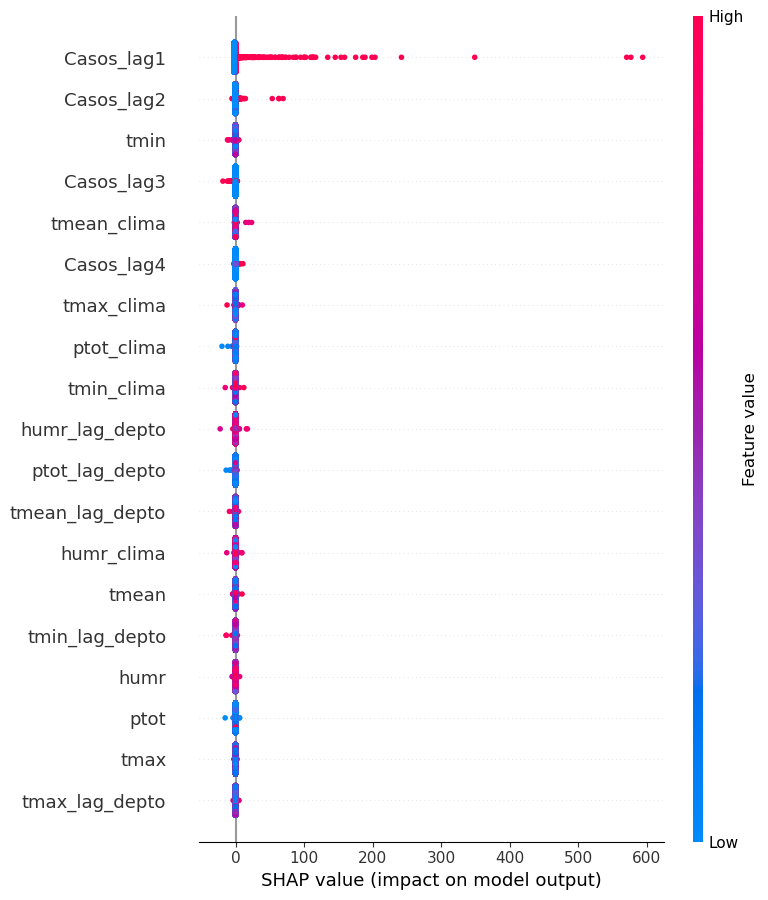


--- Gráficos de Dependencia SHAP para las 2 características más importantes ---


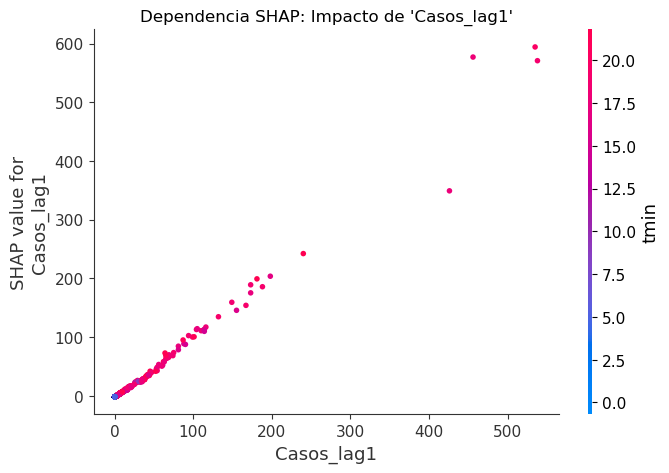

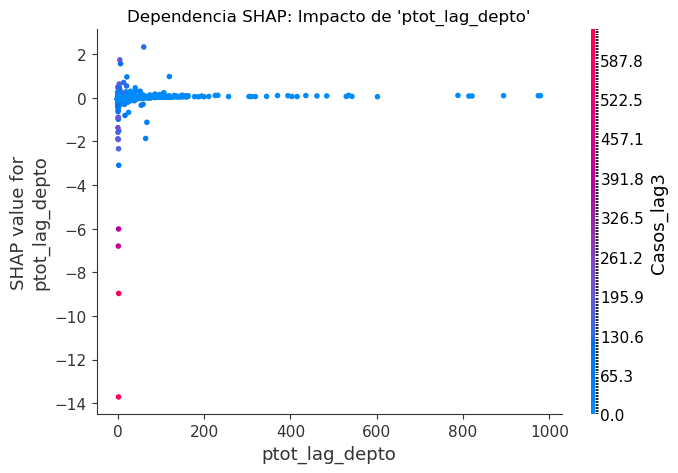

In [ ]:
import shap
# --- 6. Interpretabilidad Avanzada del Modelo con SHAP ---

# Calcular los valores SHAP puede ser computacionalmente intensivo.
# En lugar de usar todo el conjunto de prueba, tomaremos una muestra aleatoria representativa.
# 10,000 muestras es un buen balance entre velocidad y precisión para la visualización.
X_test_sample = X_test.sample(n=10000, random_state=42)

print("Creando el explicador de SHAP y calculando los valores...")

# Creamos un "explicador" que entiende cómo funciona nuestro modelo XGBoost
explainer = shap.Explainer(xgb_model)

# Calculamos los valores SHAP para nuestra muestra de datos de prueba
shap_values = explainer(X_test_sample)

print("Cálculo de valores SHAP completado. Generando gráficos...")

# Gráfico 1: SHAP Summary Plot (Beeswarm)
# Este es el gráfico más potente. Cada punto es una predicción para un distrito/semana.
# - Eje Y: Las características, ordenadas por importancia.
# - Eje X: El "valor SHAP". Un valor > 0 significa que esa característica empujó la predicción hacia arriba.
# - Color: El valor original de la característica (rojo=alto, azul=bajo).
print("\n--- Gráfico de Resumen SHAP (Beeswarm) ---")
shap.summary_plot(shap_values, X_test_sample, plot_type='dot')


# Gráfico 2: SHAP Dependence Plots
# Estos gráficos muestran cómo el valor de una variable afecta la predicción.
# Son útiles para entender relaciones no lineales.
print("\n--- Gráficos de Dependencia SHAP para las 2 características más importantes ---")

# Gráfico para la característica más importante: Casos_lag1
shap.dependence_plot("Casos_lag1", shap_values.values, X_test_sample,
                    interaction_index="auto", # El color muestra la interacción con otra variable
                    show=False)
plt.title("Dependencia SHAP: Impacto de 'Casos_lag1'")
plt.show()

# Gráfico para la segunda característica más importante: ptot_lag_depto
shap.dependence_plot("ptot_lag_depto", shap_values.values, X_test_sample,
                    interaction_index="auto",
                    show=False)
plt.title("Dependencia SHAP: Impacto de 'ptot_lag_depto'")
plt.show()

#### **Resumen de Interpretación de Gráficos SHAP**

| Gráfico | Variable(s) Principal(es) | Observaciones Clave | Interpretación Epidemiológica |
|---------|---------------------------|----------------------|-------------------------------|
| **Resumen SHAP (Beeswarm)** | `Casos_lag1` (más importante), seguido de `Casos_lag2-4`; climáticas (`ptot_lag_depto`, `tmin_lag_depto`, etc.) | - `Casos_lag1`: puntos rojos (valores altos) → predicción alta.<br>- `Casos_lag2-4`: refuerzan el patrón autorregresivo.<br>- Lluvia alta semanas atrás → valor SHAP positivo.<br>- Lluvia baja → sin efecto. | La epidemia tiene una **inercia fuerte**: la historia reciente de casos predice mejor que cualquier otra variable. La lluvia modula el riesgo, aumentando casos tras semanas lluviosas. |
| **Dependencia SHAP: `Casos_lag1`** | `Casos_lag1` (con color = `tmin`) | - Relación casi lineal y positiva.<br>- Mayor número de casos la semana pasada → mayor impacto en la predicción.<br>- Temperatura mínima no altera sustancialmente este efecto. | La epidemia se **alimenta de sí misma**. Los brotes tienen continuidad temporal independiente de la temperatura mínima. |
| **Dependencia SHAP: `ptot_lag_depto`** | Precipitación acumulada | - La mayoría de los puntos cerca de 0 (poca influencia).<br>- Con más lluvia → valor SHAP positivo (más riesgo).<br>- Outliers con valores negativos → lluvia extrema puede reducir casos. | La lluvia **favorece la transmisión**, pero en exceso puede **eliminar criaderos** y disminuir temporalmente el riesgo. |

---

**Conclusión General:**  
El modelo no solo es preciso (R² > 0.9), sino que también refleja mecanismos epidemiológicos lógicos:  
1. **Inercia epidémica** como motor principal (casos pasados → casos futuros).  
2. **Factores climáticos** como moduladores secundarios que explican variaciones adicionales en el riesgo de dengue.  


#### **Finalización del Modelo Baseline y Transición**

Hemos completado un ciclo completo de modelado:
1.  **Entrenamiento:** Construimos un modelo XGBoost para predecir a 1 semana.
2.  **Evaluación:** Obtuvimos un R² excelente de 0.9080.
3.  **Interpretación:** Usando SHAP, descubrimos que el modelo es muy preciso pero depende fuertemente de la inercia a corto plazo (`Casos_lag1`), lo que lo hace menos útil para alertas tempranas de brotes debido a su ventana temporal muy corta.

Ahora, abordamos esta limitación directamente.

---

### **7: Modelo Estratégico con Horizonte de Predicción a 4 Semanas**

**Justificación Metodológica:**

Como identificamos en el análisis de interpretabilidad, un modelo que depende excesivamente de `Casos_lag1` tiene un horizonte predictivo muy corto. Para crear un sistema de **alerta temprana**, que es el objetivo fundamental de muchos sistemas de pronóstico de enfermedades (como se discute en **Chakraborty et al.** y **Sebastianelli et al.**), necesitamos que el modelo pueda anticipar los cambios con mayor antelación.

Para lograr esto, cambiaremos el objetivo del problema. En lugar de predecir la próxima semana (un pronóstico táctico), entrenaremos el modelo para predecir de aquí a **4 semanas** (un pronóstico estratégico). Este cambio obliga al modelo a depender menos de la inercia inmediata y a dar más peso a los **impulsores fundamentales de más largo plazo**, como las condiciones climáticas (cuyos lags óptimos encontramos entre 6 y 17 semanas).

Esperamos que las métricas de precisión, como el R², sean más bajas, ya que predecir a un mes de distancia es intrínsecamente más difícil. Sin embargo, un modelo que logra un rendimiento razonable en esta tarea es significativamente más valioso para la planificación en salud pública.

Este paso consiste en re-definir nuestra variable objetivo (`y`), re-dividir los datos y entrenar un nuevo modelo XGBoost para esta nueva tarea.



Iniciando la construcción del modelo estratégico (horizonte de 4 semanas)...

Entrenando modelo para predecir 'Casos_horizonte4' con 276443 filas...
¡Entrenamiento completado!

Realizando predicciones y evaluando el modelo estratégico...

--- Resultados de la Evaluación (Horizonte 4 Semanas) ---
Raíz del Error Cuadrático Medio (RMSE): 9.1410
Coeficiente de Determinación (R²): 0.4876


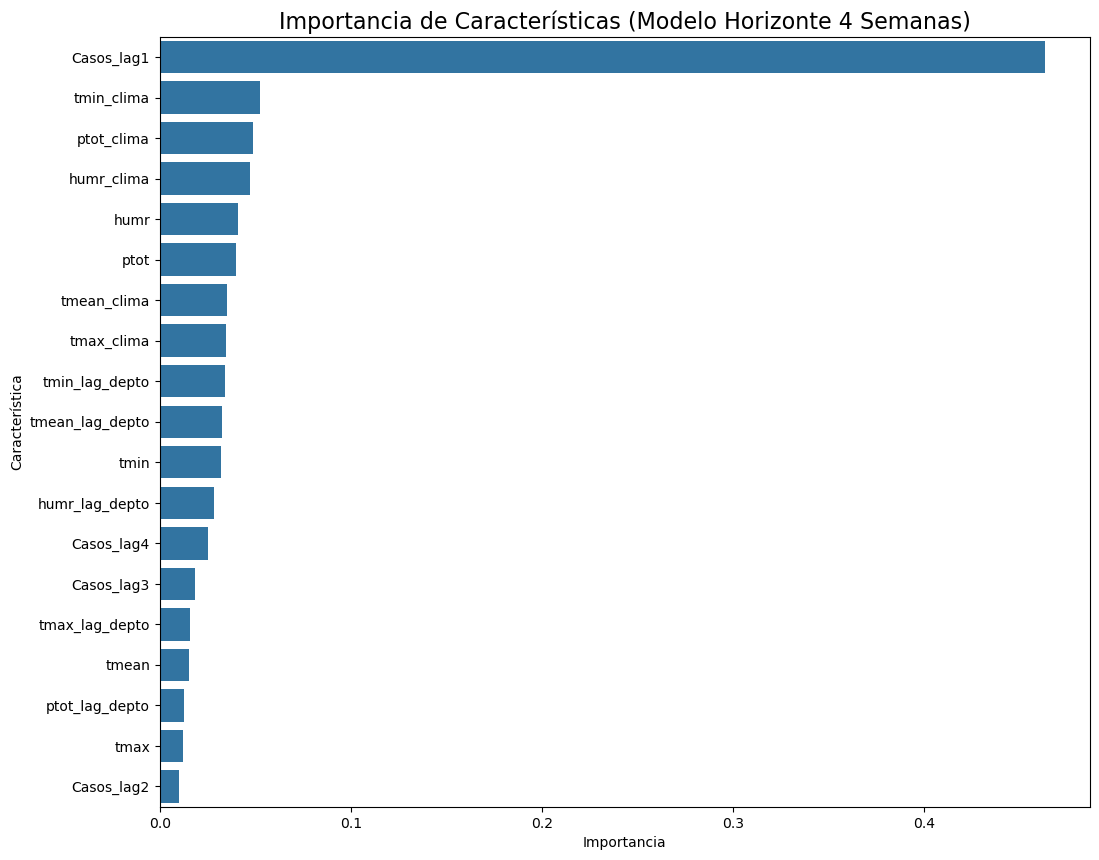


--- Top 5 Características Más Predictivas (Horizonte 4 Semanas) ---
       feature  importance
15  Casos_lag1    0.463616
7   tmin_clima    0.052350
9   ptot_clima    0.048644
8   humr_clima    0.047455
3         humr    0.041181


In [13]:
# 7: Modelo Estratégico con Horizonte de Predicción a 4 Semanas

print("Iniciando la construcción del modelo estratégico (horizonte de 4 semanas)...")

# 7.1 Re-ingeniería de la Variable Objetivo
horizonte = 4
target_horizonte = f'Casos_horizonte{horizonte}'

# Creamos la nueva variable objetivo con un shift negativo
df_model_h4 = df_model.copy()
df_model_h4[target_horizonte] = df_model_h4.groupby('UBIGEO')['Casos'].shift(-horizonte)
df_model_h4.dropna(inplace=True) # Eliminamos las filas finales que no tienen objetivo

# --- 7.2 Definición y División de Datos para el Nuevo Problema ---
features_h4 = [col for col in df_model_h4.columns if col.startswith(('t', 'h', 'p', 'Casos_lag'))]
X_h4 = df_model_h4[features_h4]
y_h4 = df_model_h4[target_horizonte]

# Usamos la misma fecha de corte que ya calculamos
X_train_h4, y_train_h4 = X_h4.loc[X_h4.index <= fecha_corte], y_h4.loc[y_h4.index <= fecha_corte]
X_test_h4, y_test_h4 = X_h4.loc[X_h4.index > fecha_corte], y_h4.loc[y_h4.index > fecha_corte]

# Filtramos los periodos anómalos del conjunto de entrenamiento
X_train_h4 = X_train_h4[mask_silencio & mask_pandemia]
y_train_h4 = y_train_h4[mask_silencio & mask_pandemia]

#  7.3 Entrenamiento del Modelo de Horizonte 4
print(f"\nEntrenando modelo para predecir '{target_horizonte}' con {X_train_h4.shape[0]} filas...")
xgb_model_h4 = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)
xgb_model_h4.fit(X_train_h4, y_train_h4)
print("¡Entrenamiento completado!")

#  7.4 Evaluación del Modelo de Horizonte 4
print("\nRealizando predicciones y evaluando el modelo estratégico...")
y_pred_h4 = xgb_model_h4.predict(X_test_h4)
rmse_h4 = np.sqrt(mean_squared_error(y_test_h4, y_pred_h4))
r2_h4 = r2_score(y_test_h4, y_pred_h4)

print("\n--- Resultados de la Evaluación (Horizonte 4 Semanas) ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_h4:.4f}")
print(f"Coeficiente de Determinación (R²): {r2_h4:.4f}")


# 7.5 Análisis de Importancia de Caracteristicas
importances_h4 = xgb_model_h4.feature_importances_
feature_names_h4 = X_train_h4.columns
feature_importance_df_h4 = pd.DataFrame({
    'feature': feature_names_h4,
    'importance': importances_h4
}).sort_values(by='importance', ascending=False)

#  Visualización de la Nueva Importancia 
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df_h4)
plt.title('Importancia de Características (Modelo Horizonte 4 Semanas)', fontsize=16)
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

print("\n--- Top 5 Características Más Predictivas (Horizonte 4 Semanas) ---")
print(feature_importance_df_h4.head(5))

### **8: Backtesting del Modelo Estratégico (Horizonte 4 Semanas)**

**Justificación Metodológica:**

Habiendo desarrollado un modelo con un horizonte de predicción estratégicamente más útil (4 semanas), ahora aplicaremos la técnica de **Validación Cruzada para Series Temporales (Backtesting)** para evaluar su robustez. Este método simula un despliegue operativo en el que el modelo se re-entrena periódicamente, proporcionando una estimación de rendimiento mucho más fiable que una única división de datos.

Al promediar las métricas de rendimiento a través de múltiples "ventanas" de tiempo, podremos afirmar con mayor confianza que el modelo no solo es teóricamente sólido, sino también estable y fiable en la práctica.

Iniciando backtesting final con evaluación y visualización correctas...

--- Ventana 1/10 ---
  Entrenando hasta: 2021-08-02, Prediciendo de: 2021-08-09 a 2022-01-03
  Resultados del Fold: RMSE = 3.0315, R² = 0.3803

--- Ventana 2/10 ---
  Entrenando hasta: 2022-01-03, Prediciendo de: 2022-01-10 a 2022-06-06
  Resultados del Fold: RMSE = 8.4523, R² = -0.7264

--- Ventana 3/10 ---
  Entrenando hasta: 2022-06-06, Prediciendo de: 2022-06-13 a 2022-11-07
  Resultados del Fold: RMSE = 2.3667, R² = 0.5409

--- Ventana 4/10 ---
  Entrenando hasta: 2022-11-07, Prediciendo de: 2022-11-14 a 2023-04-10
  Resultados del Fold: RMSE = 13.7566, R² = 0.3450

--- Ventana 5/10 ---
  Entrenando hasta: 2023-04-10, Prediciendo de: 2023-04-17 a 2023-09-11
  Resultados del Fold: RMSE = 23.0251, R² = 0.5605

--- Ventana 6/10 ---
  Entrenando hasta: 2023-09-11, Prediciendo de: 2023-09-18 a 2024-02-12
  Resultados del Fold: RMSE = 12.8468, R² = 0.4860

--- Ventana 7/10 ---
  Entrenando hasta: 2024-02-12, Predic

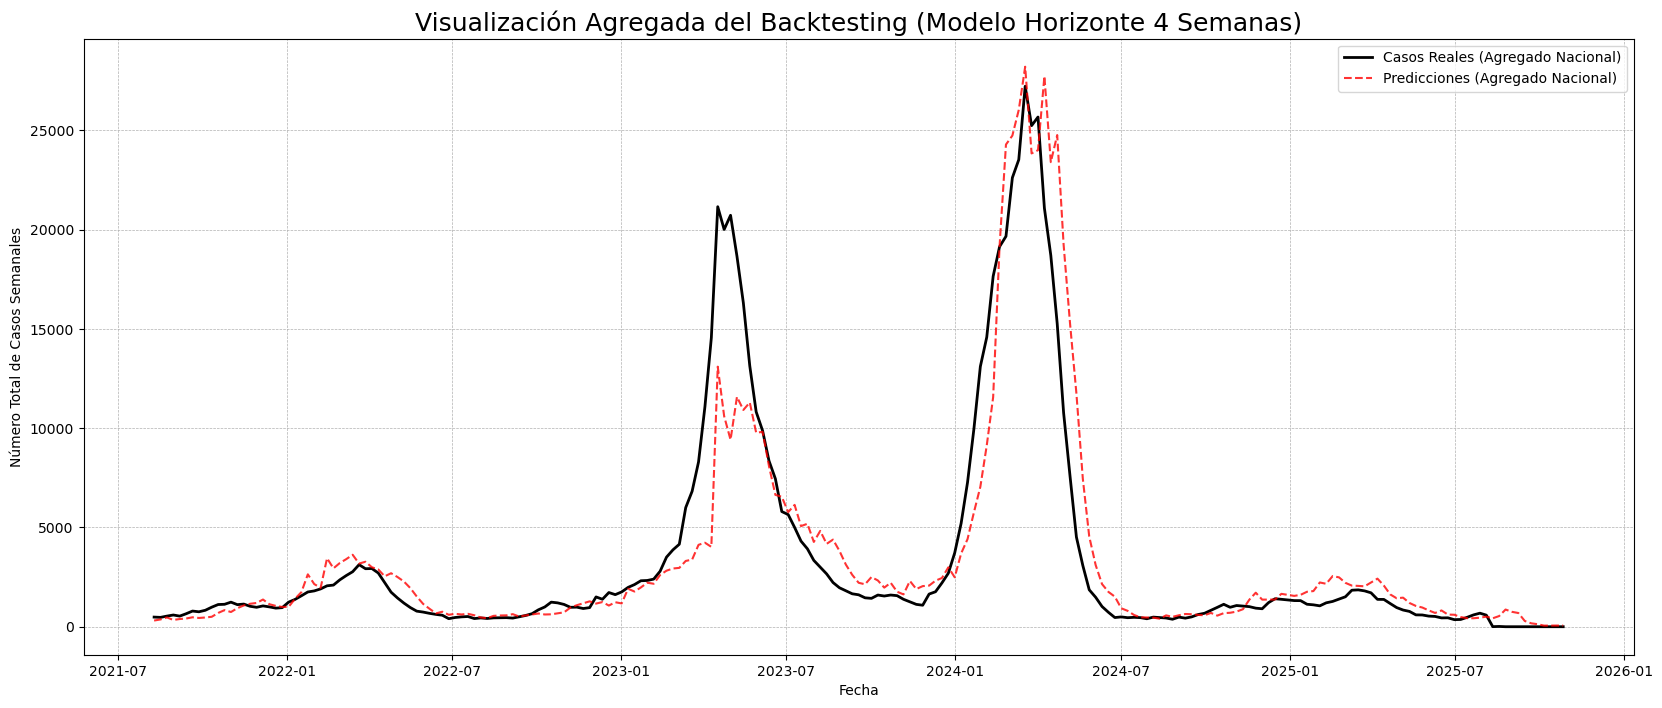

In [19]:
# Backtesting con Evaluación y Visualización

print("Iniciando backtesting final con evaluación y visualización correctas...")

# Reutilizamos la misma lógica de ventana deslizante
unique_dates = sorted(X_h4.index.unique())
n_total_weeks = len(unique_dates)
n_splits = 10
train_size_weeks = int(n_total_weeks * 0.5)
test_size_weeks = int((n_total_weeks - train_size_weeks) / n_splits)

all_predictions_df_final = pd.DataFrame()
rmse_scores_final = []
r2_scores_final = []

# Bucle para la ventana deslizante
for i in range(n_splits):
    start_train_date = unique_dates[0]
    end_train_date = unique_dates[train_size_weeks + i * test_size_weeks]
    start_test_date = unique_dates[train_size_weeks + i * test_size_weeks + 1]
    end_test_date_index = train_size_weeks + (i + 1) * test_size_weeks
    end_test_date = unique_dates[min(end_test_date_index, n_total_weeks - 1)]

    X_train_fold, y_train_fold = X_h4.loc[start_train_date:end_train_date], y_h4.loc[start_train_date:end_train_date]
    X_test_fold, y_test_fold = X_h4.loc[start_test_date:end_test_date], y_h4.loc[start_test_date:end_test_date]

    if X_test_fold.empty: continue

    # Filtrado del train set
    mask_silencio = (X_train_fold.index < periodo_silencio[0]) | (X_train_fold.index > periodo_silencio[1])
    mask_pandemia = (X_train_fold.index < periodo_pandemia[0]) | (X_train_fold.index > periodo_pandemia[1])
    X_train_fold_clean, y_train_fold_clean = X_train_fold[mask_silencio & mask_pandemia], y_train_fold[mask_silencio & mask_pandemia]
    
    print(f"\n--- Ventana {i+1}/{n_splits} ---")
    print(f"  Entrenando hasta: {end_train_date.date()}, Prediciendo de: {start_test_date.date()} a {end_test_date.date()}")
    
    fold_model = xgb.XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, objective='reg:squarederror', n_jobs=-1, random_state=42)
    fold_model.fit(X_train_fold_clean, y_train_fold_clean)
    y_pred_fold = fold_model.predict(X_test_fold)

    # Las métricas se calculan directamente sobre los datos del fold, sin agregar.
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)
    rmse_scores_final.append(rmse_fold)
    r2_scores_final.append(r2_fold)
    print(f"  Resultados del Fold: RMSE = {rmse_fold:.4f}, R² = {r2_fold:.4f}")

    # Guardamos los resultados para la visualización
    fold_results_df = pd.DataFrame({'Casos_Reales': y_test_fold, 'Casos_Predichos': y_pred_fold}, index=y_test_fold.index)
    all_predictions_df_final = pd.concat([all_predictions_df_final, fold_results_df])

# resultados finales
print("\n\n--- Resultados Finales del Backtesting (Promedio a Nivel Distrito) ---")
print(f"RMSE Promedio por distrito: {np.mean(rmse_scores_final):.4f} (Desv. Est.: {np.std(rmse_scores_final):.4f})")
print(f"R² Promedio por distrito:   {np.mean(r2_scores_final):.4f} (Desv. Est.: {np.std(r2_scores_final):.4f})")

# visualización
reales_agg_viz = all_predictions_df_final.groupby(all_predictions_df_final.index)['Casos_Reales'].sum()
predichos_agg_viz = all_predictions_df_final.groupby(all_predictions_df_final.index)['Casos_Predichos'].sum()

plt.figure(figsize=(20, 8))
plt.plot(reales_agg_viz.index, reales_agg_viz, label='Casos Reales (Agregado Nacional)', color='black', linewidth=2)
plt.plot(predichos_agg_viz.index, predichos_agg_viz, label='Predicciones (Agregado Nacional)', color='red', linestyle='--', alpha=0.8)
plt.title('Visualización Agregada del Backtesting (Modelo Horizonte 4 Semanas)', fontsize=18)
plt.ylabel('Número Total de Casos Semanales')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### **Siguientes Pasos**

El primer paso consiste en documentar y refinar el modelo actual basado en Machine Learning. Es necesario redactar un resumen técnico que recoja de manera clara y ordenada todo lo desarrollado en los dos notebooks previos. Esto incluye describir el proceso de limpieza de datos, justificar la construcción de las variables rezagadas a nivel departamental, explicar la elección estratégica del horizonte de predicción a cuatro semanas (t+4), y detallar los resultados obtenidos en los ejercicios de backtesting. Asimismo, se incorporará la interpretación de resultados mediante los gráficos SHAP, de modo que quede explícito cómo y por qué el modelo llega a sus predicciones. Para elevar el rigor metodológico, se realizará también un ajuste sistemático de hiperparámetros empleando herramientas como GridSearchCV, lo que permitirá evaluar combinaciones óptimas de parámetros como el número de estimadores, la profundidad máxima y la tasa de aprendizaje, con el objetivo de mejorar el desempeño del modelo y superar el R² promedio actual.

En paralelo, se abrirá un nuevo frente metodológico a través del enfoque estadístico. Para ello se desarrollará un tercer notebook (03_Modelo_Estadistico_R.ipynb), en el cual se cargarán los datos mediante R y se procederá a definir un modelo de carácter bayesiano o autoregresivo, como INLA o ARIMA. El conocimiento obtenido en la etapa de Machine Learning guiará la selección de predictores, incorporando aquellos que demostraron ser más influyentes, como Casos_lag1, la temperatura mínima (tmin_clima) o la precipitación acumulada rezagada por departamento (ptot_lag_depto). Este nuevo modelo permitirá realizar una comparación directa entre el enfoque predictivo basado en ML y el enfoque estadístico clásico, siguiendo la lógica metodológica de trabajos previos como los de Caro Ferreyra y Chakraborty.

Finalmente, se llevará a cabo un análisis más profundo de los errores del modelo actual. Para así poder identificar en qué contextos o regiones la capacidad predictiva se ve más comprometida. Se explorará si las predicciones resultan sistemáticamente menos precisas en determinados departamentos —por ejemplo, comparando la selva, la costa y la sierra— o incluso a nivel provincial y distrital. Este análisis permitirá detectar patrones de error que apunten a la necesidad de enriquecer el modelo con nuevas variables explicativas. Podrían incluirse dimensiones socioeconómicas, de movilidad o de urbanización, tal como sugieren investigaciones recientes en la literatura. En conjunto, este paso complementará la validación cruzada de los enfoques ML y estadístico, y abrirá el camino para una versión más robusta e integral del modelo de predicción de brotes de dengue.